In [1]:
import pathlib
import joblib
import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ALLCools.integration import calculate_overlap_score, confusion_matrix_clustering
#from ALLCools.plot import *

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

In [2]:
mc_cat_key = "AgingMajorType"
atac_cat_key = "celltype_final"

## count

In [3]:
mc_annot= pd.read_csv('/home/qzeng/project/aging/metadata/240104_mC_META.csv', index_col = 0)
atac_annot = pd.read_csv('/home/qzeng/project/aging/metadata/Luisa.ATAC.Multiome.Meta.csv', index_col = 'cell_id')

/home/qz/miniconda3/envs/allcools/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
adata_merge = anndata.read_h5ad("final_with_coords.atac_correct.h5ad")
adata_merge

AnnData object with n_obs × n_vars = 826988 × 272436
    obs: 'Modalities', 'leiden'
    uns: 'leiden', 'neighbors'
    obsm: 'X_pca', 'X_tsne'
    obsp: 'connectivities', 'distances'

In [5]:
adata_merge.obs['Modalities'].unique()

['snmC', 'snm3C', 'ATAC', 'Multiome']
Categories (4, object): ['ATAC', 'Multiome', 'snm3C', 'snmC']

In [6]:
mc_meta = adata_merge.obs[adata_merge.obs["Modalities"] == "snmC"].copy()
atac_meta = adata_merge.obs[adata_merge.obs["Modalities"] == "ATAC"].copy()

In [7]:
mc_meta[mc_cat_key] = mc_annot[mc_cat_key]
mc_meta.head()

,Modalities,leiden,AgingMajorType
AMB_200205_9mo_2A_3A_1_P1-1-F3-A1,snmC,9,L6 CT CTX Glut
AMB_200205_9mo_2A_3A_1_P1-1-F3-A13,snmC,4,L2/3 IT CTX Glut
AMB_200205_9mo_2A_3A_1_P1-1-F3-A14,snmC,4,L2/3 IT CTX Glut
AMB_200205_9mo_2A_3A_1_P1-1-F3-A2,snmC,16,Pvalb Gaba
AMB_200205_9mo_2A_3A_1_P1-1-F3-B1,snmC,14,L4/5 IT CTX Glut


In [8]:
atac_meta[atac_cat_key] = atac_annot[atac_cat_key]
atac_meta.head()

,Modalities,leiden,celltype_final
Male:8wk_8E_rep2:AAACGCAAGCAAAGGAACAGAC,ATAC,53,CA2-FC-IG Glut
Male:8wk_8E_rep2:AAACGCAAGCACCTCACTCGAA,ATAC,13,Sst Gaba
Male:8wk_8E_rep2:AAACGCAAGCAGATTGGACAAG,ATAC,53,CA2-FC-IG Glut
Male:8wk_8E_rep2:AAACGCAAGCAGCGAATAACCC,ATAC,53,CA2-FC-IG Glut
Male:8wk_8E_rep2:AAACGCAAGCAGGCTGCGTCTA,ATAC,7,CA1-ProS Glut


In [9]:
use_mc_cts = joblib.load('/home/qzeng/project/aging/metadata/shared_use_cts')
luisa_annot = atac_meta['celltype_final'].unique()


shared_cts = list(set(use_mc_cts) & set(luisa_annot))
shared_cts = [ct for ct in shared_cts if ct.endswith('NN') == False]
len(shared_cts)

22

In [10]:
# for ct in use_mc_cts:
#     if ct not in luisa_annot and ct.endswith('NN') == False:
#         print(ct)

In [11]:
# for ct in luisa_annot:
#     if ct not in use_mc_cts and ct.endswith('NN') == False:
#         print(ct)

In [12]:
use_mc_cts = shared_cts + ['STR D1 Gaba','STR D2 Gaba','MEA-COA Glut','L4/5 IT CTX Glut','STR Gaba']
use_atac_cts = shared_cts + ['STR D12 Gaba','COA Glut','STR Prox1 Lhx6 Gaba'] #'CA2-FC-IG Glut',

In [13]:
mc_meta = mc_meta[mc_meta[mc_cat_key].isin(use_mc_cts)]
atac_meta = atac_meta[atac_meta[atac_cat_key].isin(use_atac_cts)]

In [14]:
os_mat = calculate_overlap_score(
    atac_meta[[atac_cat_key, "leiden"]], mc_meta[[mc_cat_key, "leiden"]]
)

In [15]:
os_mat.to_hdf(f"ATAC-{atac_cat_key}.mC-{mc_cat_key}.overlap_score.hdf", key="data")

## plot

In [16]:
os_mat = pd.read_hdf(f"ATAC-{atac_cat_key}.mC-{mc_cat_key}.overlap_score.hdf", key="data")
os_mat.head()

AgingMajorType,CA1-ProS Glut,CA3 Glut,CEA-BST Gaba,DG Glut,L2/3 IT CTX Glut,L2/3 IT ENT Glut,L2/3 IT PPP Glut,L4/5 IT CTX Glut,L5 ET CTX Glut,L5 IT CTX Glut,...,MEA-COA Glut,Pvalb Gaba,STR D1 Gaba,STR D1 Sema5a Gaba,STR D2 Gaba,STR Gaba,STR-PAL Chst9 Gaba,SUB-ProS Glut,Sst Gaba,Vip Gaba
celltype_final,,,,,,,,,,,,,,,,,,,,,
CA1-ProS Glut,0.925782,0.006825,0.001300,0.002875,0.001104,0.003806,0.013079,0.013831,0.001184,0.004612,...,0.001091,0.006595,0.000300,0.000057,0.010264,0.001199,0.000459,0.012614,0.009978,0.002287
CA3 Glut,0.009800,0.850495,0.001543,0.001329,0.000748,0.002995,0.005897,0.004197,0.000553,0.001226,...,0.003613,0.005528,0.000390,0.000000,0.002248,0.000511,0.000613,0.001431,0.002146,0.002460
CEA-BST Gaba,0.003740,0.000886,0.786296,0.000742,0.001133,0.002664,0.002524,0.004179,0.000220,0.000440,...,0.026929,0.004179,0.017958,0.026620,0.011524,0.003269,0.040480,0.000000,0.006159,0.002785
COA Glut,0.003099,0.001440,0.016227,0.000973,0.000593,0.002529,0.002787,0.004049,0.000000,0.000178,...,0.806900,0.003925,0.000913,0.000535,0.001882,0.001976,0.004508,0.000000,0.003386,0.003120
DG Glut,0.008728,0.002086,0.001446,0.932383,0.000924,0.002492,0.003342,0.009710,0.000161,0.001128,...,0.001236,0.003030,0.000382,0.000036,0.008769,0.001192,0.000506,0.000286,0.008584,0.001705


In [17]:
(
    query_group,
    ref_group,
    confusion_matrix,
    g,
    modularity_score,
) = confusion_matrix_clustering(
    confusion_matrix=os_mat,
    min_value=0.1,
    max_value=0.9,
    partition_type=None,
    resolution=1,
    seed=0,
)
print(f"Modularity: {modularity_score:.3f}")

Modularity: 0.926


In [18]:
atac_order = ['CEA-BST Gaba', 'MEA-BST Gaba','Pvalb Gaba', 'Sst Gaba','STR-PAL Chst9 Gaba', 
              'STR D1 Sema5a Gaba', 'STR D12 Gaba','STR Prox1 Lhx6 Gaba','Vip Gaba','Lamp5 Gaba',
               'CA1-ProS Glut', 'CA3 Glut', 'DG Glut',  'SUB-ProS Glut',  'COA Glut','LA-BLA-BMA-PA Glut',
              'L5 NP CTX Glut','L5 ET CTX Glut', 'L6 CT CTX Glut','L6b/CT ENT Glut','L2/3 IT ENT Glut', 'L2/3 IT PPP Glut',
              'L2/3 IT CTX Glut',  'L5 IT CTX Glut', 'L6 IT CTX Glut']
len(atac_order)

25

In [19]:
mc_order = ['CEA-BST Gaba','MEA-BST Gaba','Pvalb Gaba','Sst Gaba', 'STR-PAL Chst9 Gaba', 
            'STR D1 Sema5a Gaba', 'STR D2 Gaba', 'STR D1 Gaba','STR Gaba', 'Vip Gaba','Lamp5 Gaba',
            'CA1-ProS Glut', 'CA3 Glut', 'DG Glut','SUB-ProS Glut','MEA-COA Glut','LA-BLA-BMA-PA Glut',
            'L5 NP CTX Glut', 'L5 ET CTX Glut', 'L6 CT CTX Glut','L6b/CT ENT Glut','L2/3 IT ENT Glut','L2/3 IT PPP Glut', 
            'L2/3 IT CTX Glut', 'L4/5 IT CTX Glut', 'L5 IT CTX Glut','L6 IT CTX Glut']
len(mc_order)

27

In [20]:
confusion_matrix = confusion_matrix.loc[atac_order, mc_order]

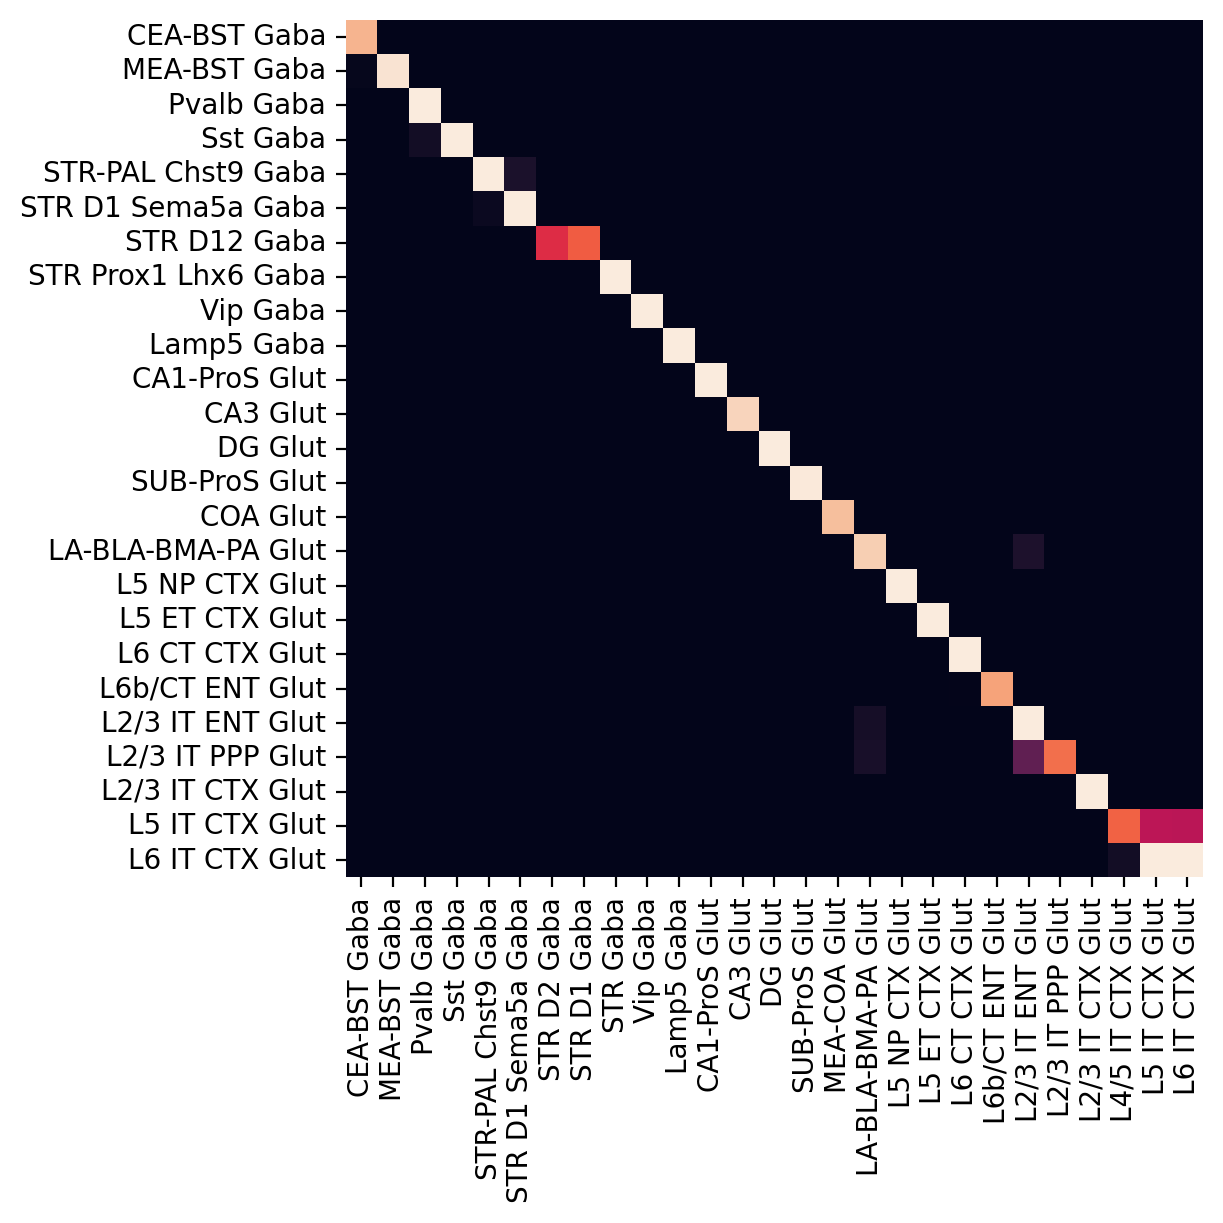

In [21]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=200, constrained_layout = True)
sns.heatmap(confusion_matrix, cbar=False,
            xticklabels=True,yticklabels=True,rasterized = True,
            ax=ax, vmin=0.1, vmax=0.9)
fig.savefig('mc_atac.confusion.matrix.pdf', bbox_inches = 'tight')

In [22]:
False, cmap=plt.cm.gray

SyntaxError: can't assign to keyword (3145750680.py, line 1)